## Student Information

In [1]:
# Student Name: Daniel Nemirovskiy, Nathan Seaney
# Student ID: DEN200001, NES210004
# Course Name: CS 4375-002

## Importing Necessary Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy
import random
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

## Setting GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Creating Directories for Results

In [4]:
os.makedirs('./results', exist_ok=True)
os.makedirs('./results/runs', exist_ok=True)

## Obtaining the Datasets

In [5]:
def get_datasets(dataset_name, batch_size=32, num_workers=2):
    """
    Load and preprocess datasets. Split training data into train and validation sets.

    Implemented by: Daniel Nemirovskiy (100%)
    """
    # Define transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # loading the dataset
    if dataset_name.lower() == 'cifar10':
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                                    download=True, transform=transform_train)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                                   download=True, transform=transform_test)
        dataset_info = {
            'name': 'CIFAR-10',
            'num_classes': 10,
            'classes': ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
            'input_channels': 3,
            'input_shape': (32, 32)
        }
        
    elif dataset_name.lower() == 'svhn':
        train_dataset = torchvision.datasets.SVHN(root='./data', split='train',
                                                download=True, transform=transform_train)
        test_dataset = torchvision.datasets.SVHN(root='./data', split='test',
                                               download=True, transform=transform_test)
        dataset_info = {
            'name': 'SVHN',
            'num_classes': 10,
            'classes': tuple(str(i) for i in range(10)),  # Digits 0-9
            'input_channels': 3,
            'input_shape': (32, 32)
        }
    else:
        raise ValueError(f"Dataset {dataset_name} not supported. Use 'cifar10' or 'svhn'.")
    
    # split training data into training and validation sets 90% train and 10% validation
    val_size = int(0.1 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))
    
    # data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size,
                             shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_subset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)

    # outputting number of samples for each subset
    print(f"Dataset: {dataset_info['name']}")
    print(f"Number of training samples: {len(train_subset)}")
    print(f"Number of validation samples: {len(val_subset)}")
    print(f"Number of testing samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader, dataset_info

## Visualizing the Data Samples

In [6]:
def visualize_dataset_samples(loader, classes, num_samples=5):
    """
    Visualize samples from a dataset.

    Implemented by: Daniel Nemirovskiy (100%)
    """
    samples, labels = next(iter(loader))
    
    # moving samples to CPU and convert to numpy
    samples = samples.cpu().numpy()
    
    # unnormalizing images
    samples = samples / 2 + 0.5
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(samples))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.transpose(samples[i], (1, 2, 0)))
        plt.title(classes[labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Implementing the LeNet Model

In [7]:
class LeNet(nn.Module):
    """
    LeNet-5 CNN architecture

    Implemented by: Daniel Nemirovskiy (100%)
    """
    def __init__(self, num_classes=10, input_channels=3):
        super(LeNet, self).__init__()
        # first convolutional layer with 6 filters of size 5x5, followed by ReLU and 2x2 max pooling
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # second convolutional layer with 16 filters of size 5x5, followed by ReLU and 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        # first convolutional block
        x = self.pool1(F.relu(self.conv1(x)))
        
        # second convolutional block
        x = self.pool2(F.relu(self.conv2(x)))
        
        # flattening
        x = x.view(x.size(0), -1)
        
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# testing the model
def test_lenet():
    model = LeNet()
    sample_input = torch.randn(1, 3, 32, 32)
    output = model(sample_input)
    print(f"LeNet Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Implementing the ResNet-18 Model

In [8]:
class BasicBlock(nn.Module):
    """
    Basic block for ResNet-18 and ResNet-34

    Implemented by: Daniel Nemirovskiy (100%)
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # main path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # shortcut connection
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet18(nn.Module):
    """
    ResNet-18 implementation

    Implemented by: Daniel Nemirovskiy (100%)
    """
    def __init__(self, num_classes=10, input_channels=3):
        super(ResNet18, self).__init__()
        
        # first convolutional layer
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # four layers of the network with multiple residual blocks
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        # global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Creating a layer of residual blocks

        Implemented by: Daniel Nemirovskiy (100%)
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # first convolution
        out = F.relu(self.bn1(self.conv1(x)))
        
        # ResNet layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        # global average pooling
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        
        # fcl
        out = self.fc(out)
        
        return out

# testing the model
def test_resnet18():
    model = ResNet18()
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"ResNet-18 Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Implementing our Custom FCNN

In [9]:
class CustomCNN(nn.Module):
    """
    Our Custom FCNN implmenetation

    Implemented by: Nathan Seaney (95%), Daniel Nemirovskiy (5%)
    """
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        # initial Downsampling using strided convolution instead of max pooling
        self.conv1 = nn.Conv2d(3, 24, kernel_size=7, stride=2, padding=3)
        self.act1 = nn.GELU()  # Non-standard activation for diversity

        # depthwise separable convolution block
        self.dwconv2 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1, groups=24)
        self.pwconv2 = nn.Conv2d(24, 48, kernel_size=1)
        self.act2 = nn.GELU()

        # dilated convolution block (to capture context without downsampling)
        self.dilated_conv = nn.Conv2d(48, 64, kernel_size=3, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.SiLU()

        # global average pooling instead of flatten + dense
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # classifier
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.act1(self.conv1(x))

        x = self.act2(self.pwconv2(self.dwconv2(x)))

        x = self.act3(self.bn3(self.dilated_conv(x)))

        x = self.global_avg_pool(x) 
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.fc(x)

        return x

# testing the model
def test_customcnn():
    model = CustomCNN(
        filters=(16, 32, 64), 
        kernel_sizes=(3, 3, 3), 
        fc_sizes=(128,),
        dropout_rate=0.2,
        use_batch_norm=True
    )
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"CustomCNN Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Model Selector function

In [10]:
def get_model(model_name, num_classes=10, input_channels=3):
    """
    Return model instance based on name.

    Implemented by: Daniel Nemirovskiy (100%)
    """
    if model_name.lower() == 'lenet':
        return LeNet(num_classes=num_classes, input_channels=input_channels)
    elif model_name.lower() == 'resnet18':
        return ResNet18(num_classes=num_classes, input_channels=input_channels)
    elif model_name.lower() == 'customcnn':
        return CustomCNN(num_classes=num_classes)
    else:
        raise ValueError(f"Model {model_name} not supported. Use 'lenet', 'resnet18', or 'customcnn'.")


## Defining the Training Function

In [11]:
def train_model(model, dataloaders, criterion, optimizer, device, 
               num_epochs=25, model_name="model", dataset_name="dataset",
               scheduler=None, log_step=100, save_dir="./results"):
    """
    Train a model and evaluate on validation set.

    Implemented by: Daniel Nemirovskiy (100%)
    """
    since = time.time()
    
    # setting up the TensorBoard writer
    writer = SummaryWriter(f"{save_dir}/runs/{model_name}_{dataset_name}")
    
    # initializing training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # copy initial weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # train loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # splitting training and validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterating over batches
            data_iterator = tqdm(dataloaders[phase], desc=f'{phase} - Epoch {epoch+1}/{num_epochs}')
            for i, (inputs, labels) in enumerate(data_iterator):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward pass + optimize, only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        # logging to TensorBoard
                        global_step = epoch * len(dataloaders['train']) + i
                        if global_step % log_step == 0:
                            writer.add_scalar(f'Loss/{phase}', loss.item(), global_step)
                
                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # updating the learning rate if scheduler is provided
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            # calculating epoch statistics
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # logging epoch statistics
            writer.add_scalar(f'Epoch_Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Epoch_Accuracy/{phase}', epoch_acc, epoch)
            
            # history updates
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # outputting loss and accuracy of epoch
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # saving the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy': best_acc,
                }, f"{save_dir}/{model_name}_{dataset_name}_best.pth")
        
        # checkpoint after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, f"{save_dir}/{model_name}_{dataset_name}_checkpoint.pth")
        
        print()
    
    # calculating total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # adding model graph to TensorBoard
    writer.add_graph(model, next(iter(dataloaders['train']))[0].to(device))
    writer.close()
    
    # loading best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

## Evaluating the Models

In [12]:
def evaluate_model(model, dataloader, criterion, device, dataset_name="dataset"):
    """
    Evaluate a model on test set

    Implemented by: Daniel Nemirovskiy (100%)
    """
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    all_preds = []
    all_labels = []
    
    # iterating over batches
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f'Evaluating on {dataset_name}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # stats
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # storing predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # stats
    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)

    # outputting loss and accuracy for evaluation
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc.item(), all_preds, all_labels

## Plotting the Training History and Confusion Matrix

In [13]:
def plot_training_history(history, title, save_dir="./results"):
    """
    Plot training and validation loss and accuracy curves

    Implemented by: Daniel Nemirovskiy (100%)
    """
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plotting loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # plotting accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # saving plotted visualizations to file for report
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_history.png")
    plt.show()
    
    print(f"Training history plot saved to {save_dir}/{title.replace(' ', '_')}_history.png")

def plot_confusion_matrix(y_true, y_pred, classes, title, save_dir="./results"):
    """
    Plot confusion matrix

    Implemented by: Daniel Nemirovskiy (100%)
    """
    # computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    
    # creating a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    
    # adding labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # saving matrix visualiation
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_confusion_matrix.png")
    plt.show()
    
    print(f"Confusion matrix plot saved to {save_dir}/{title.replace(' ', '_')}_confusion_matrix.png")


## Defining the Classification Report Function

In [14]:
def generate_classification_report(y_true, y_pred, classes, title, save_dir="./results"):
    """
    Generate and save classification report

    Implemented by: Daniel Nemirovskiy (100%)
    """
    # generating the classification report
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    
    # converting to dataframe for visualization
    df_report = pd.DataFrame(report).transpose()
    
    # saving report to CSV
    os.makedirs(save_dir, exist_ok=True)
    df_report.to_csv(f"{save_dir}/{title.replace(' ', '_')}_classification_report.csv")
    
    print(f"Classification report saved to {save_dir}/{title.replace(' ', '_')}_classification_report.csv")
    
    return df_report

## Model Comparison

In [15]:
def compare_models(results, title, save_dir="./results"):
    """
    Generate bar plots comparing different models

    Implemented by: Daniel Nemirovskiy (100%)
    """
    # extracting data
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]
    losses = [results[model]['loss'] for model in models]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # plotting accuracy
    bars1 = ax1.bar(models, accuracies, color='skyblue')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1.0)
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    # plotting loss
    bars2 = ax2.bar(models, losses, color='salmon')
    ax2.set_title('Model Loss Comparison')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Loss')
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # saving the comparison
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_comparison.png")
    plt.show()
    
    print(f"Model comparison plot saved to {save_dir}/{title.replace(' ', '_')}_comparison.png")


## Running the Final Tests

In [16]:
def run_experiment(dataset_names=['cifar10', 'svhn'], 
                  model_names=['lenet', 'resnet18', 'customcnn'],
                  batch_size=128, epochs=30, learning_rate=0.001, weight_decay=1e-4,
                  num_workers=2, save_dir='./results', log_step=100):
    """
    Run the complete experiment pipeline.

    Implemented by: Daniel Nemirovskiy (100%)
    """
    # results dictionary to store metrics for all models and datasets
    results = defaultdict(dict)
    
    # iterating over each dataset
    for dataset_name in dataset_names:
        print(f"\n{'='*50}")
        print(f"Processing dataset: {dataset_name}")
        print(f"{'='*50}")
        
        # load the dataset
        train_loader, val_loader, test_loader, dataset_info = get_datasets(
            dataset_name, batch_size=batch_size, num_workers=num_workers
        )
        
        # visualizing samples
        visualize_dataset_samples(train_loader, dataset_info['classes'])
        
        # creating dataloader dictionary
        dataloaders = {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader
        }
        
        # iterating over the models
        for model_name in model_names:
            print(f"\n{'-'*40}")
            print(f"Training {model_name} on {dataset_name}")
            print(f"{'-'*40}")
            
            # model initialization
            model = get_model(
                model_name, 
                num_classes=dataset_info['num_classes'],
                input_channels=dataset_info['input_channels']
            )
            model = model.to(device)
            
            # printing # of params for model
            print(f"Model: {model_name}")
            print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
            
            # defining loss and optimization functions
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            # learning rate scheduler
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            
            # training the model
            model, history = train_model(
                model, dataloaders, criterion, optimizer, device,
                num_epochs=epochs, model_name=model_name, dataset_name=dataset_name,
                scheduler=scheduler, log_step=log_step, save_dir=save_dir
            )
            
            # plotting history
            plot_training_history(
                history, f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # model evaluation on test set
            test_loss, test_acc, test_preds, test_labels = evaluate_model(
                model, test_loader, criterion, device, dataset_name=dataset_name
            )
            
            # storing results
            results[dataset_name][model_name] = {
                'accuracy': test_acc,
                'loss': test_loss
            }
            
            # plotting confusion matrix
            plot_confusion_matrix(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # generating classification report
            report_df = generate_classification_report(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            print("\nClassification Report:")
            display(report_df)
            
        # model comparison by dataset
        compare_models(
            results[dataset_name], f"Model Comparison on {dataset_name}", save_dir=save_dir
        )
    
    # outputting final results
    print("\nFinal Results:")
    for dataset_name in dataset_names:
        print(f"\nDataset: {dataset_name}")
        for model_name in model_names:
            print(f"  {model_name}: Accuracy = {results[dataset_name][model_name]['accuracy']:.4f}, "
                  f"Loss = {results[dataset_name][model_name]['loss']:.4f}")
    
    return results

## Evaluating Trained Models

In [17]:
def evaluate_trained_model(model_name, dataset_name, checkpoint_path):
    """
    Evaluate a trained model on test data.

    Implemented by: Daniel Nemirovskiy (100%)
    """
    # loading the dataset
    _, _, test_loader, dataset_info = get_datasets(
        dataset_name, batch_size=128, num_workers=2
    )
    
    # model initialization
    model = get_model(
        model_name, 
        num_classes=dataset_info['num_classes'],
        input_channels=dataset_info['input_channels']
    )
    model = model.to(device)
    
    # loading checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    # defining the loss function
    criterion = nn.CrossEntropyLoss()
    
    # evaluating the model on test set
    test_loss, test_acc, test_preds, test_labels = evaluate_model(
        model, test_loader, criterion, device, dataset_name=dataset_name
    )
    
    # plotting the confusion matrix
    plot_confusion_matrix(
        test_labels, test_preds, dataset_info['classes'],
        f"{model_name} on {dataset_name} Test Set", save_dir='./results'
    )
    
    # generating a classification report
    report_df = generate_classification_report(
        test_labels, test_preds, dataset_info['classes'],
        f"{model_name} on {dataset_name} Test Set", save_dir='./results'
    )
    
    print("\nClassification Report:")
    display(report_df)
    
    return test_acc, test_loss

## Running the Experiment


Processing dataset: cifar10
Dataset: CIFAR-10
Number of training samples: 45000
Number of validation samples: 5000
Number of testing samples: 10000


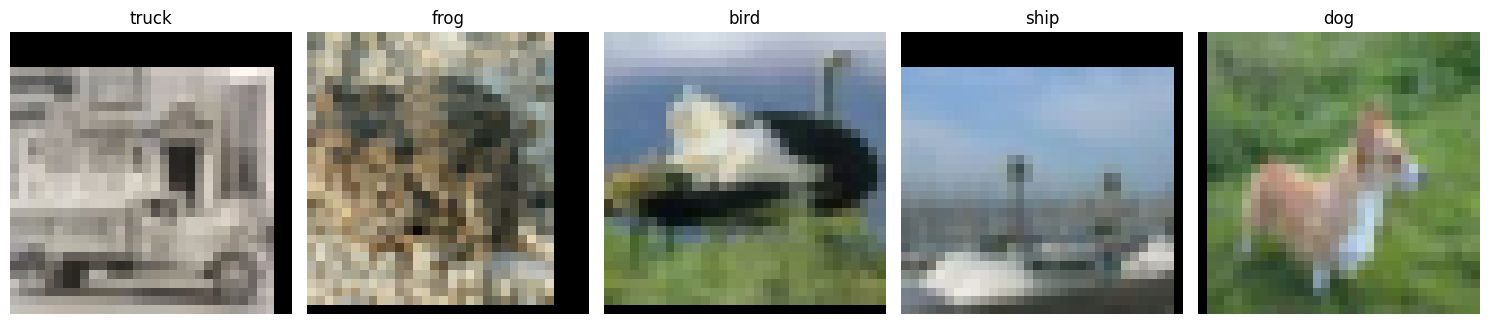


----------------------------------------
Training lenet on cifar10
----------------------------------------
Model: lenet
Number of parameters: 83126
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.8101 Acc: 0.3323


val - Epoch 1/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6311 Acc: 0.4098

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.5539 Acc: 0.4310


val - Epoch 2/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5077 Acc: 0.4394

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4531 Acc: 0.4697


val - Epoch 3/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4293 Acc: 0.4808

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3881 Acc: 0.4962


val - Epoch 4/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3727 Acc: 0.5000

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3248 Acc: 0.5177


val - Epoch 5/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3253 Acc: 0.5142

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.2912 Acc: 0.5347


val - Epoch 6/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2658 Acc: 0.5418

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.2564 Acc: 0.5490


val - Epoch 7/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2305 Acc: 0.5570

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1832 Acc: 0.5755


val - Epoch 8/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2132 Acc: 0.5602

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1711 Acc: 0.5801


val - Epoch 9/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1958 Acc: 0.5694

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1677 Acc: 0.5808


val - Epoch 10/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1791 Acc: 0.5816

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1632 Acc: 0.5835


val - Epoch 11/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1670 Acc: 0.5768

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1516 Acc: 0.5862


val - Epoch 12/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1807 Acc: 0.5704

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1489 Acc: 0.5894


val - Epoch 13/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1860 Acc: 0.5724

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1491 Acc: 0.5884


val - Epoch 14/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1686 Acc: 0.5814

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1382 Acc: 0.5929


val - Epoch 15/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1686 Acc: 0.5730

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1337 Acc: 0.5940


val - Epoch 16/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1818 Acc: 0.5672

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1375 Acc: 0.5921


val - Epoch 17/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1632 Acc: 0.5860

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1366 Acc: 0.5948


val - Epoch 18/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1616 Acc: 0.5866

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1343 Acc: 0.5936


val - Epoch 19/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1600 Acc: 0.5838

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1358 Acc: 0.5960


val - Epoch 20/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1634 Acc: 0.5836

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1336 Acc: 0.5946


val - Epoch 21/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1686 Acc: 0.5878

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1336 Acc: 0.5942


val - Epoch 22/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1632 Acc: 0.5778

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1341 Acc: 0.5944


val - Epoch 23/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1563 Acc: 0.5796

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1348 Acc: 0.5946


val - Epoch 24/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1542 Acc: 0.5844

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1341 Acc: 0.5975


val - Epoch 25/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1699 Acc: 0.5752

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1342 Acc: 0.5960


val - Epoch 26/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1623 Acc: 0.5836

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1301 Acc: 0.5963


val - Epoch 27/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1549 Acc: 0.5842

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1312 Acc: 0.5961


val - Epoch 28/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1744 Acc: 0.5800

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1309 Acc: 0.5974


val - Epoch 29/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1660 Acc: 0.5764

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.1346 Acc: 0.5940


val - Epoch 30/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1630 Acc: 0.5852

Training complete in 17m 59s
Best val Acc: 0.5878


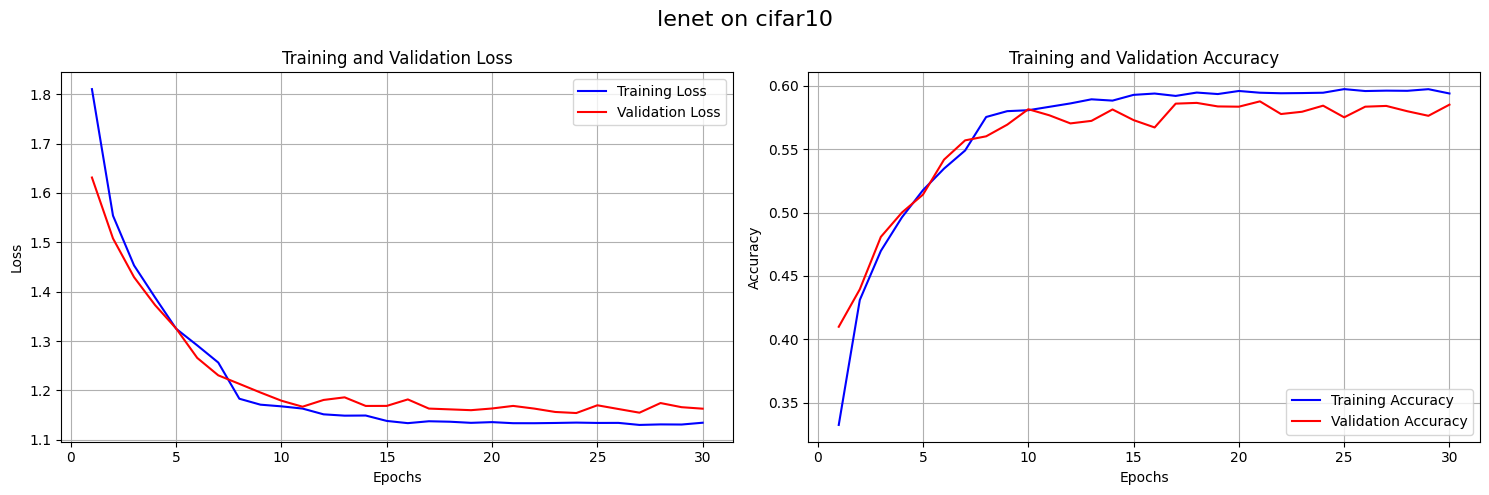

Training history plot saved to ./results/lenet_on_cifar10_history.png


Evaluating on cifar10:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.0754 Acc: 0.6212


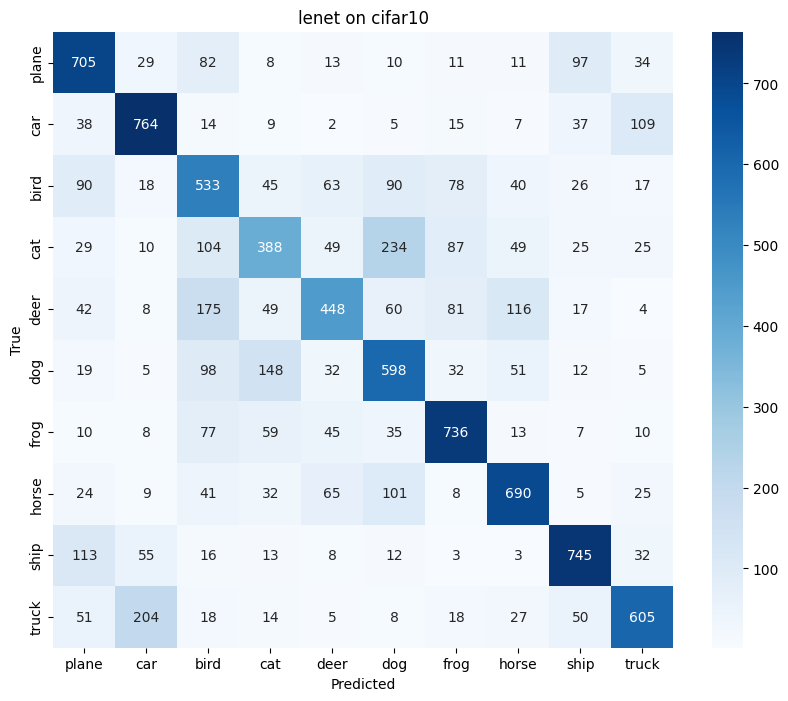

Confusion matrix plot saved to ./results/lenet_on_cifar10_confusion_matrix.png
Classification report saved to ./results/lenet_on_cifar10_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
plane,0.628903,0.7050,0.664781,1000.0000
car,0.688288,0.7640,0.724171,1000.0000
bird,0.460276,0.5330,0.493976,1000.0000
cat,0.507190,0.3880,0.439660,1000.0000
deer,0.613699,0.4480,0.517919,1000.0000
dog,0.518647,0.5980,0.555504,1000.0000
frog,0.688494,0.7360,0.711455,1000.0000
horse,0.685204,0.6900,0.687593,1000.0000
ship,0.729677,0.7450,0.737259,1000.0000
truck,0.698614,0.6050,0.648446,1000.0000



----------------------------------------
Training resnet18 on cifar10
----------------------------------------
Model: resnet18
Number of parameters: 11173962
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4943 Acc: 0.4514


val - Epoch 1/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2852 Acc: 0.5354

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.0191 Acc: 0.6356


val - Epoch 2/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.9992 Acc: 0.6496

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.8264 Acc: 0.7083


val - Epoch 3/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7558 Acc: 0.7314

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.6941 Acc: 0.7554


val - Epoch 4/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.8516 Acc: 0.7032

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.6111 Acc: 0.7882


val - Epoch 5/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.6449 Acc: 0.7778

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.5512 Acc: 0.8104


val - Epoch 6/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7077 Acc: 0.7588

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.5004 Acc: 0.8278


val - Epoch 7/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.7077 Acc: 0.7678

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.3592 Acc: 0.8780


val - Epoch 8/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3723 Acc: 0.8720

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.3141 Acc: 0.8925


val - Epoch 9/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3633 Acc: 0.8760

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2901 Acc: 0.9002


val - Epoch 10/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3478 Acc: 0.8778

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2714 Acc: 0.9058


val - Epoch 11/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3440 Acc: 0.8802

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2573 Acc: 0.9114


val - Epoch 12/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3375 Acc: 0.8854

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2433 Acc: 0.9148


val - Epoch 13/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3331 Acc: 0.8852

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2289 Acc: 0.9214


val - Epoch 14/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3388 Acc: 0.8818

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2030 Acc: 0.9300


val - Epoch 15/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3195 Acc: 0.8930

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1932 Acc: 0.9348


val - Epoch 16/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3269 Acc: 0.8892

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1894 Acc: 0.9356


val - Epoch 17/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3163 Acc: 0.8948

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1847 Acc: 0.9375


val - Epoch 18/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3312 Acc: 0.8878

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1816 Acc: 0.9383


val - Epoch 19/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3126 Acc: 0.8940

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1802 Acc: 0.9379


val - Epoch 20/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3189 Acc: 0.8942

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1771 Acc: 0.9386


val - Epoch 21/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3188 Acc: 0.8964

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1734 Acc: 0.9414


val - Epoch 22/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3129 Acc: 0.8976

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1717 Acc: 0.9411


val - Epoch 23/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3334 Acc: 0.8872

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1725 Acc: 0.9406


val - Epoch 24/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3229 Acc: 0.8952

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1718 Acc: 0.9405


val - Epoch 25/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3154 Acc: 0.8924

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1718 Acc: 0.9412


val - Epoch 26/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3080 Acc: 0.8970

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1747 Acc: 0.9409


val - Epoch 27/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3159 Acc: 0.8952

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1708 Acc: 0.9414


val - Epoch 28/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3272 Acc: 0.8908

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1678 Acc: 0.9417


val - Epoch 29/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3111 Acc: 0.8946

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1706 Acc: 0.9409


val - Epoch 30/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 0.3268 Acc: 0.8916

Training complete in 27m 18s
Best val Acc: 0.8976


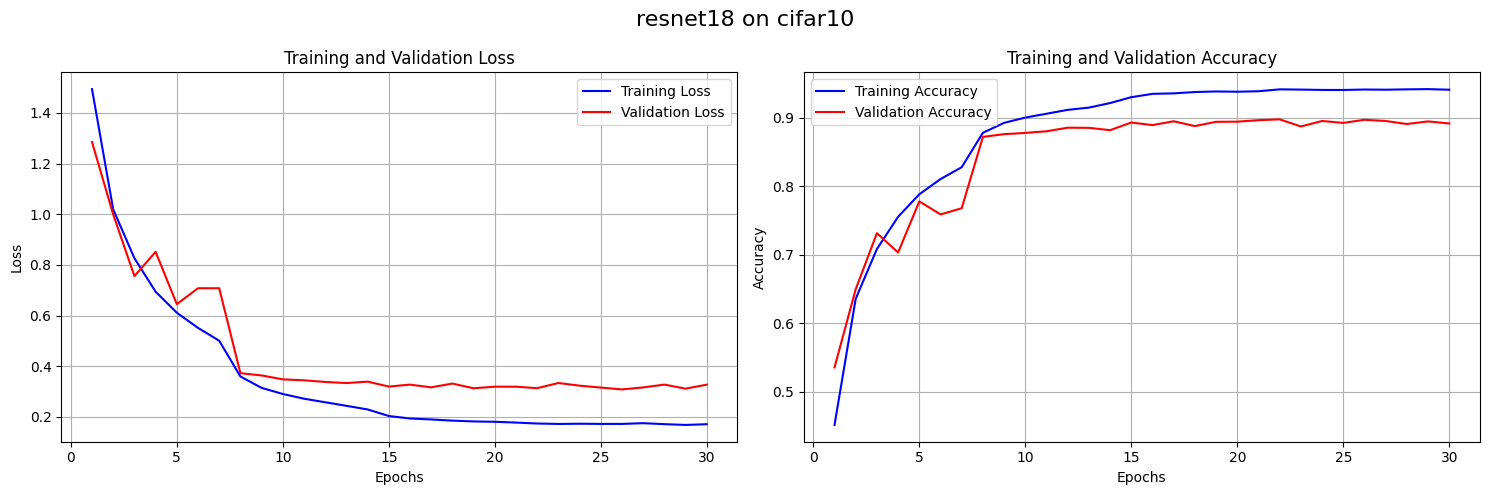

Training history plot saved to ./results/resnet18_on_cifar10_history.png


Evaluating on cifar10:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.3486 Acc: 0.8960


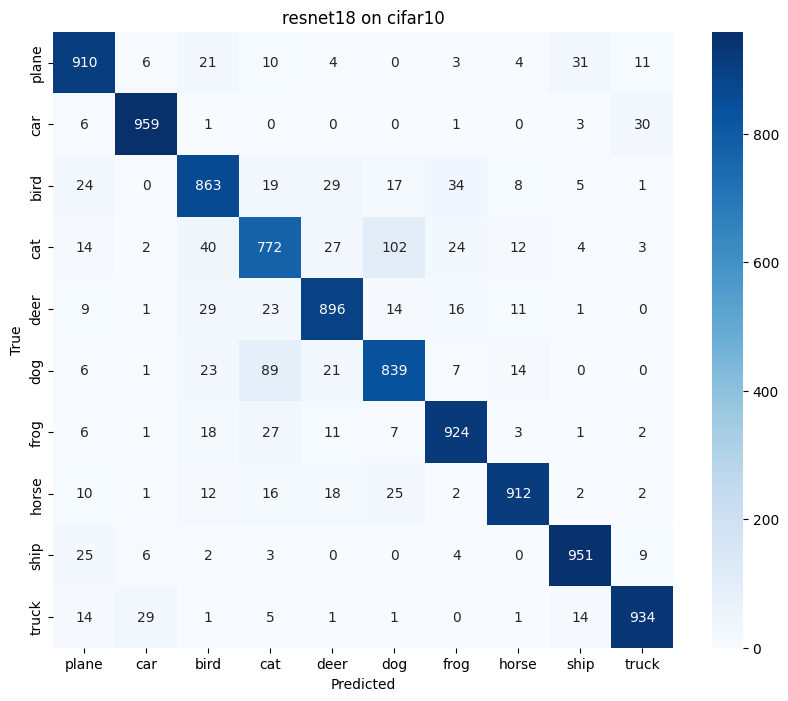

Confusion matrix plot saved to ./results/resnet18_on_cifar10_confusion_matrix.png
Classification report saved to ./results/resnet18_on_cifar10_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
plane,0.888672,0.910,0.899209,1000.000
car,0.953280,0.959,0.956132,1000.000
bird,0.854455,0.863,0.858706,1000.000
cat,0.800830,0.772,0.786151,1000.000
deer,0.889772,0.896,0.892875,1000.000
dog,0.834826,0.839,0.836908,1000.000
frog,0.910345,0.924,0.917122,1000.000
horse,0.945078,0.912,0.928244,1000.000
ship,0.939723,0.951,0.945328,1000.000
truck,0.941532,0.934,0.937751,1000.000



----------------------------------------
Training customcnn on cifar10
----------------------------------------
Model: customcnn
Number of parameters: 33482
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.8930 Acc: 0.2894


val - Epoch 1/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7201 Acc: 0.3586

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.6953 Acc: 0.3672


val - Epoch 2/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6247 Acc: 0.3976

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.6273 Acc: 0.3928


val - Epoch 3/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5535 Acc: 0.4378

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.5656 Acc: 0.4207


val - Epoch 4/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5236 Acc: 0.4444

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.5055 Acc: 0.4444


val - Epoch 5/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4899 Acc: 0.4518

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4660 Acc: 0.4638


val - Epoch 6/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4089 Acc: 0.4884

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.4134 Acc: 0.4865


val - Epoch 7/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3549 Acc: 0.5108

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3715 Acc: 0.5054


val - Epoch 8/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3221 Acc: 0.5294

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3595 Acc: 0.5122


val - Epoch 9/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3158 Acc: 0.5362

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3578 Acc: 0.5122


val - Epoch 10/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3118 Acc: 0.5394

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3511 Acc: 0.5140


val - Epoch 11/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3042 Acc: 0.5366

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3465 Acc: 0.5146


val - Epoch 12/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2974 Acc: 0.5426

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3398 Acc: 0.5174


val - Epoch 13/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2920 Acc: 0.5394

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3360 Acc: 0.5220


val - Epoch 14/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2924 Acc: 0.5376

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3296 Acc: 0.5234


val - Epoch 15/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2830 Acc: 0.5406

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3296 Acc: 0.5234


val - Epoch 16/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2895 Acc: 0.5482

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3256 Acc: 0.5236


val - Epoch 17/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2868 Acc: 0.5428

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3275 Acc: 0.5253


val - Epoch 18/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2833 Acc: 0.5492

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3279 Acc: 0.5221


val - Epoch 19/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2869 Acc: 0.5432

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3266 Acc: 0.5273


val - Epoch 20/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2814 Acc: 0.5426

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3284 Acc: 0.5252


val - Epoch 21/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2827 Acc: 0.5450

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3247 Acc: 0.5242


val - Epoch 22/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2833 Acc: 0.5462

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3255 Acc: 0.5280


val - Epoch 23/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2801 Acc: 0.5398

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3269 Acc: 0.5232


val - Epoch 24/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2823 Acc: 0.5432

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3227 Acc: 0.5265


val - Epoch 25/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2879 Acc: 0.5442

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3291 Acc: 0.5241


val - Epoch 26/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2822 Acc: 0.5502

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3279 Acc: 0.5230


val - Epoch 27/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2821 Acc: 0.5446

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3266 Acc: 0.5243


val - Epoch 28/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2842 Acc: 0.5506

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3301 Acc: 0.5248


val - Epoch 29/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2847 Acc: 0.5452

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 1.3261 Acc: 0.5261


val - Epoch 30/30:   0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2847 Acc: 0.5384

Training complete in 17m 48s
Best val Acc: 0.5506


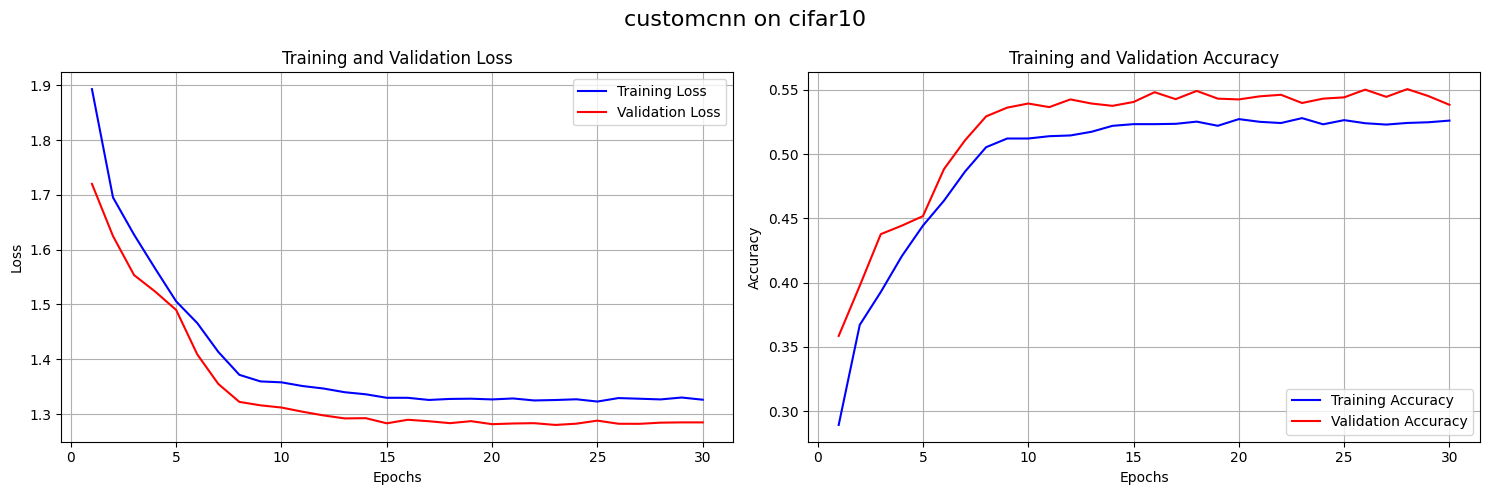

Training history plot saved to ./results/customcnn_on_cifar10_history.png


Evaluating on cifar10:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.2688 Acc: 0.5411


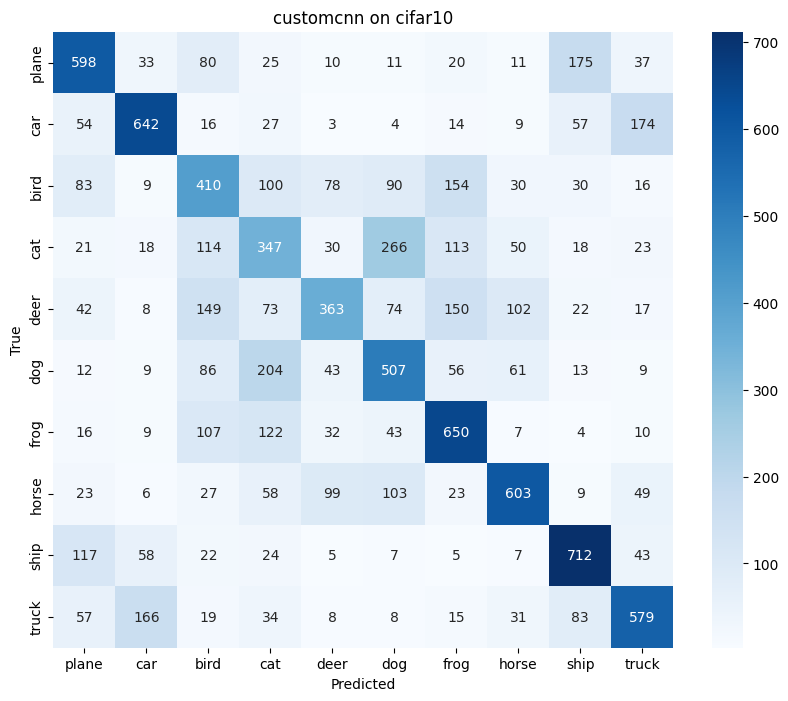

Confusion matrix plot saved to ./results/customcnn_on_cifar10_confusion_matrix.png
Classification report saved to ./results/customcnn_on_cifar10_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
plane,0.584555,0.5980,0.591201,1000.0000
car,0.670146,0.6420,0.655771,1000.0000
bird,0.398058,0.4100,0.403941,1000.0000
cat,0.342209,0.3470,0.344588,1000.0000
deer,0.540984,0.3630,0.434470,1000.0000
dog,0.455526,0.5070,0.479886,1000.0000
frog,0.541667,0.6500,0.590909,1000.0000
horse,0.661910,0.6030,0.631083,1000.0000
ship,0.634016,0.7120,0.670749,1000.0000
truck,0.605016,0.5790,0.591722,1000.0000


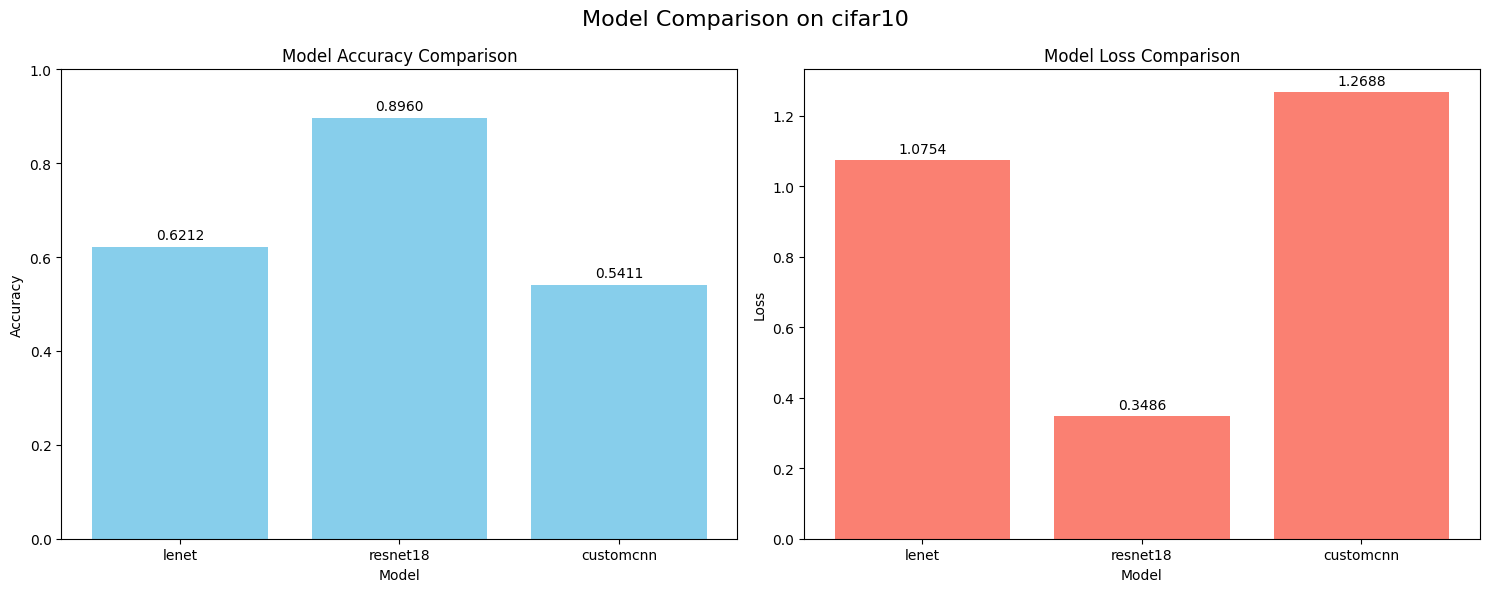

Model comparison plot saved to ./results/Model_Comparison_on_cifar10_comparison.png

Processing dataset: svhn
Dataset: SVHN
Number of training samples: 65932
Number of validation samples: 7325
Number of testing samples: 26032


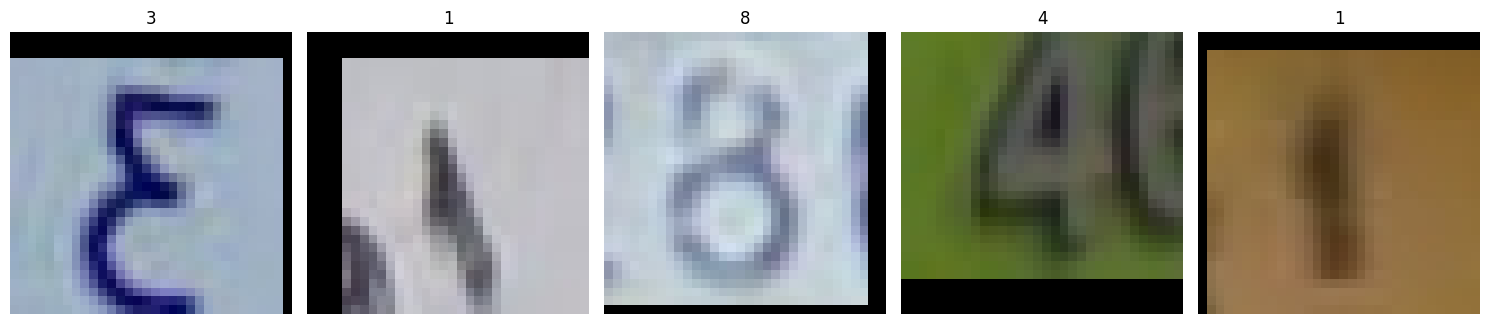


----------------------------------------
Training lenet on svhn
----------------------------------------
Model: lenet
Number of parameters: 83126
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.9652 Acc: 0.3011


val - Epoch 1/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.5569 Acc: 0.4653

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.2916 Acc: 0.5639


val - Epoch 2/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.1289 Acc: 0.6291

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0280 Acc: 0.6633


val - Epoch 3/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.9948 Acc: 0.6819

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.8955 Acc: 0.7124


val - Epoch 4/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.8619 Acc: 0.7263

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.8221 Acc: 0.7352


val - Epoch 5/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.8494 Acc: 0.7319

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.7739 Acc: 0.7519


val - Epoch 6/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.7766 Acc: 0.7530

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.7379 Acc: 0.7647


val - Epoch 7/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.7112 Acc: 0.7704

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6825 Acc: 0.7845


val - Epoch 8/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6854 Acc: 0.7885

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6693 Acc: 0.7884


val - Epoch 9/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6689 Acc: 0.7918

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6599 Acc: 0.7916


val - Epoch 10/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6619 Acc: 0.7980

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6595 Acc: 0.7923


val - Epoch 11/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6576 Acc: 0.7936

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6551 Acc: 0.7922


val - Epoch 12/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6530 Acc: 0.7977

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6477 Acc: 0.7953


val - Epoch 13/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6557 Acc: 0.7926

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6496 Acc: 0.7940


val - Epoch 14/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6476 Acc: 0.7956

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6429 Acc: 0.7969


val - Epoch 15/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6434 Acc: 0.7985

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6378 Acc: 0.8000


val - Epoch 16/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6472 Acc: 0.7989

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6367 Acc: 0.7981


val - Epoch 17/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6441 Acc: 0.7989

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6418 Acc: 0.7997


val - Epoch 18/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6370 Acc: 0.8008

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6386 Acc: 0.7997


val - Epoch 19/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6471 Acc: 0.7945

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6388 Acc: 0.7988


val - Epoch 20/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6441 Acc: 0.7977

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6366 Acc: 0.7993


val - Epoch 21/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6479 Acc: 0.7984

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6356 Acc: 0.8006


val - Epoch 22/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6464 Acc: 0.7963

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6342 Acc: 0.8021


val - Epoch 23/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6449 Acc: 0.7940

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6367 Acc: 0.7990


val - Epoch 24/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6464 Acc: 0.7936

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6398 Acc: 0.7974


val - Epoch 25/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6513 Acc: 0.7974

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6374 Acc: 0.7995


val - Epoch 26/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6450 Acc: 0.7990

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6347 Acc: 0.8000


val - Epoch 27/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6430 Acc: 0.8005

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6326 Acc: 0.8007


val - Epoch 28/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6520 Acc: 0.7959

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6367 Acc: 0.8005


val - Epoch 29/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6482 Acc: 0.7955

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.6386 Acc: 0.7989


val - Epoch 30/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.6384 Acc: 0.8015

Training complete in 21m 46s
Best val Acc: 0.8015


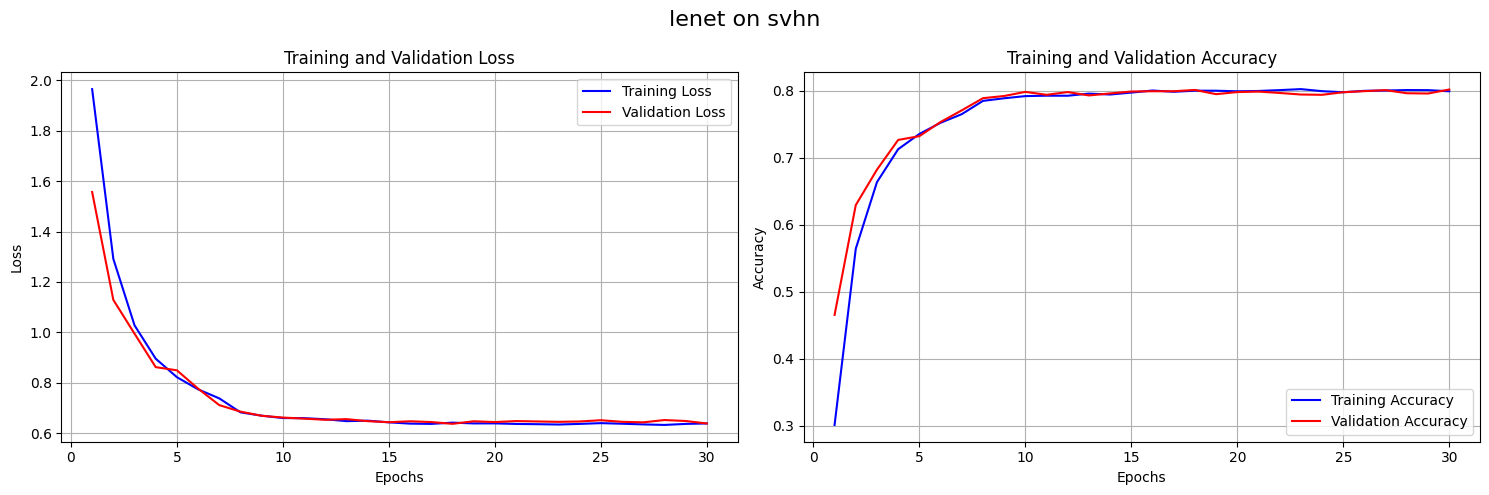

Training history plot saved to ./results/lenet_on_svhn_history.png


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 0.5567 Acc: 0.8302


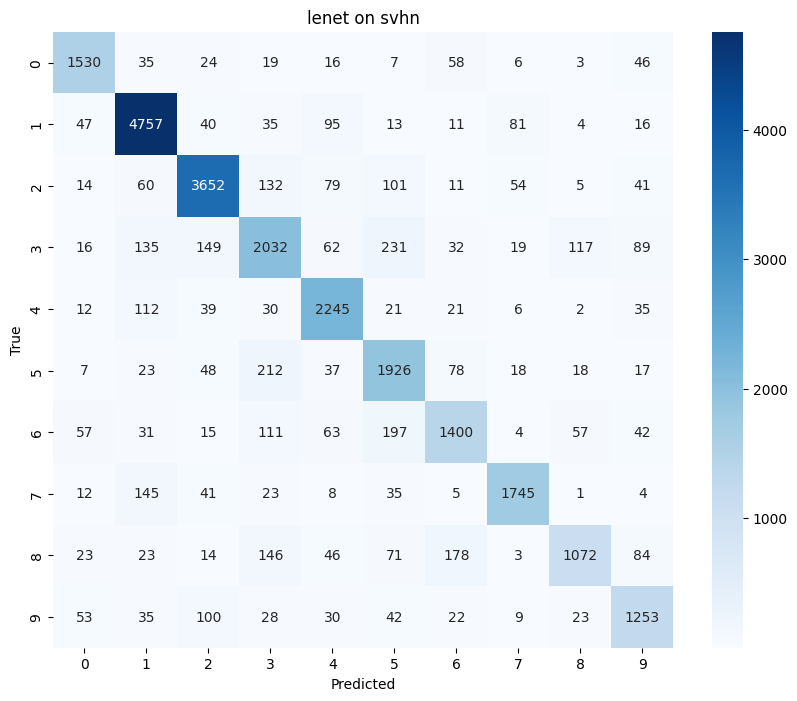

Confusion matrix plot saved to ./results/lenet_on_svhn_confusion_matrix.png
Classification report saved to ./results/lenet_on_svhn_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.863919,0.877294,0.870555,1744.000000
1,0.888163,0.932928,0.909995,5099.000000
2,0.885978,0.880212,0.883085,4149.000000
3,0.734104,0.705066,0.719292,2882.000000
4,0.837374,0.889814,0.862798,2523.000000
5,0.728442,0.807886,0.766110,2384.000000
6,0.770925,0.708144,0.738202,1977.000000
7,0.897172,0.864289,0.880424,2019.000000
8,0.823349,0.645783,0.723835,1660.000000
9,0.770129,0.785580,0.777778,1595.000000



----------------------------------------
Training resnet18 on svhn
----------------------------------------
Model: resnet18
Number of parameters: 11173962
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.9742 Acc: 0.6719


val - Epoch 1/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.5704 Acc: 0.8203

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.4121 Acc: 0.8731


val - Epoch 2/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4446 Acc: 0.8616

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.3504 Acc: 0.8942


val - Epoch 3/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3916 Acc: 0.8800

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.3171 Acc: 0.9042


val - Epoch 4/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.4539 Acc: 0.8655

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.2954 Acc: 0.9116


val - Epoch 5/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3689 Acc: 0.8896

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.2876 Acc: 0.9148


val - Epoch 6/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3126 Acc: 0.9040

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.2695 Acc: 0.9211


val - Epoch 7/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.3004 Acc: 0.9132

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1970 Acc: 0.9440


val - Epoch 8/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.2009 Acc: 0.9413

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1735 Acc: 0.9518


val - Epoch 9/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1931 Acc: 0.9453

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1643 Acc: 0.9541


val - Epoch 10/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1948 Acc: 0.9459

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1598 Acc: 0.9557


val - Epoch 11/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1870 Acc: 0.9463

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1491 Acc: 0.9596


val - Epoch 12/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1905 Acc: 0.9448

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1438 Acc: 0.9604


val - Epoch 13/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1851 Acc: 0.9477

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1407 Acc: 0.9614


val - Epoch 14/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1858 Acc: 0.9459

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1227 Acc: 0.9669


val - Epoch 15/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1827 Acc: 0.9513

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1195 Acc: 0.9685


val - Epoch 16/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1813 Acc: 0.9499

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1169 Acc: 0.9691


val - Epoch 17/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1797 Acc: 0.9502

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1142 Acc: 0.9701


val - Epoch 18/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1800 Acc: 0.9502

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1140 Acc: 0.9701


val - Epoch 19/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1817 Acc: 0.9494

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1120 Acc: 0.9703


val - Epoch 20/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1770 Acc: 0.9518

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1102 Acc: 0.9705


val - Epoch 21/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1784 Acc: 0.9513

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1092 Acc: 0.9716


val - Epoch 22/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1775 Acc: 0.9509

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1086 Acc: 0.9719


val - Epoch 23/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1748 Acc: 0.9524

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1095 Acc: 0.9713


val - Epoch 24/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1787 Acc: 0.9504

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1084 Acc: 0.9716


val - Epoch 25/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1761 Acc: 0.9539

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1076 Acc: 0.9714


val - Epoch 26/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1782 Acc: 0.9503

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1081 Acc: 0.9715


val - Epoch 27/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1797 Acc: 0.9517

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1083 Acc: 0.9711


val - Epoch 28/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1825 Acc: 0.9502

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1072 Acc: 0.9719


val - Epoch 29/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1835 Acc: 0.9510

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 0.1064 Acc: 0.9721


val - Epoch 30/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 0.1833 Acc: 0.9510

Training complete in 34m 51s
Best val Acc: 0.9539


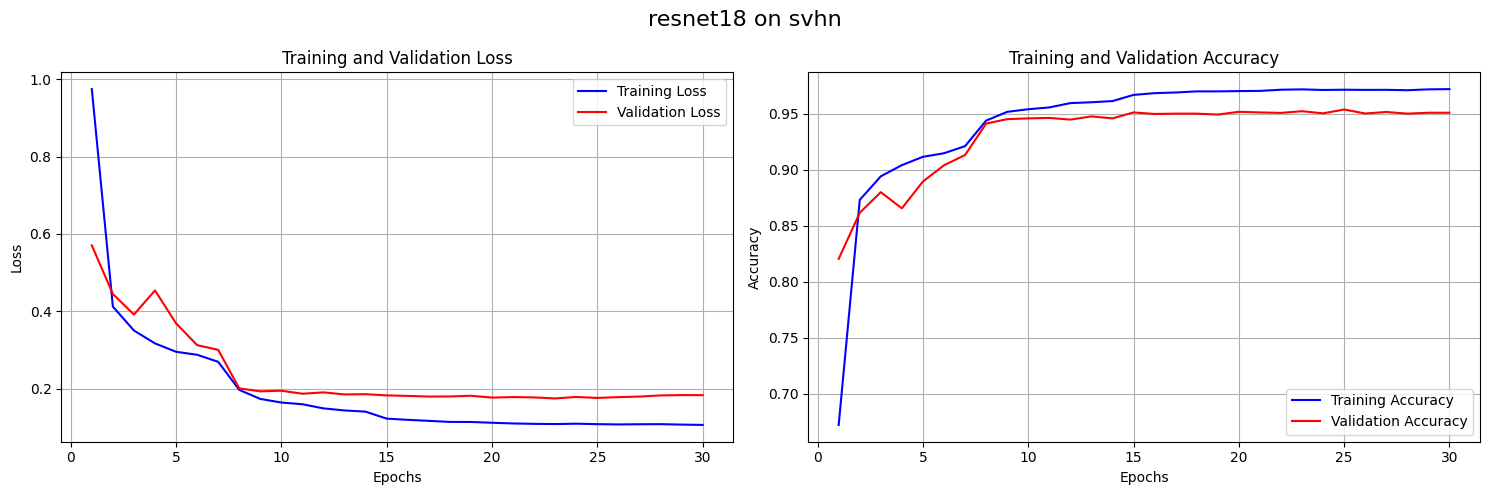

Training history plot saved to ./results/resnet18_on_svhn_history.png


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 0.1507 Acc: 0.9611


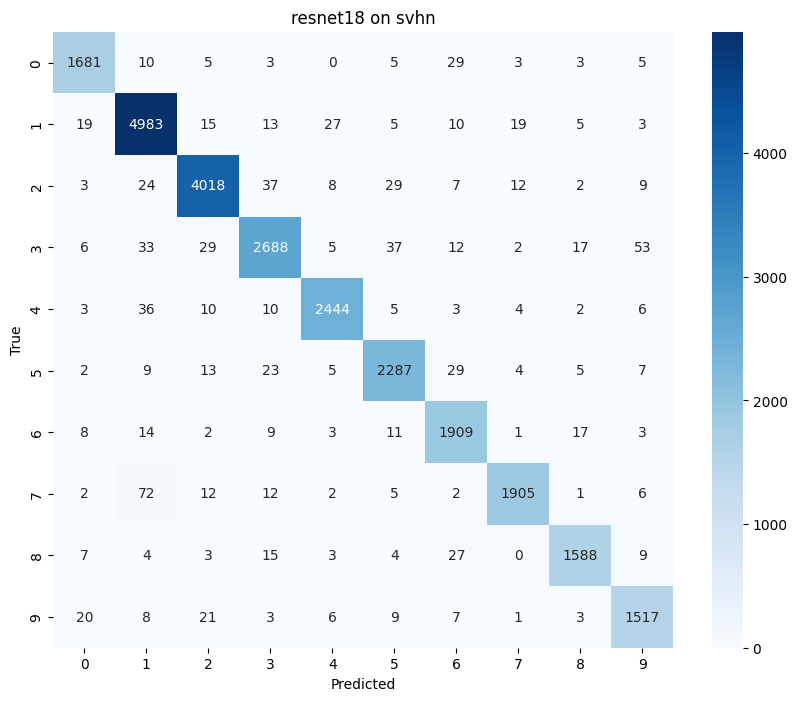

Confusion matrix plot saved to ./results/resnet18_on_svhn_confusion_matrix.png
Classification report saved to ./results/resnet18_on_svhn_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.960023,0.963876,0.961946,1744.000000
1,0.959561,0.977250,0.968325,5099.000000
2,0.973353,0.968426,0.970883,4149.000000
3,0.955563,0.932686,0.943986,2882.000000
4,0.976428,0.968688,0.972543,2523.000000
5,0.954109,0.959312,0.956704,2384.000000
6,0.938084,0.965604,0.951645,1977.000000
7,0.976422,0.943536,0.959698,2019.000000
8,0.966525,0.956627,0.961550,1660.000000
9,0.937577,0.951097,0.944289,1595.000000



----------------------------------------
Training customcnn on svhn
----------------------------------------
Model: customcnn
Number of parameters: 33482
Epoch 1/30
----------


train - Epoch 1/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 2.1752 Acc: 0.2230


val - Epoch 1/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 2.0563 Acc: 0.2661

Epoch 2/30
----------


train - Epoch 2/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.9486 Acc: 0.3093


val - Epoch 2/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.8545 Acc: 0.3454

Epoch 3/30
----------


train - Epoch 3/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.7474 Acc: 0.3945


val - Epoch 3/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.7385 Acc: 0.4106

Epoch 4/30
----------


train - Epoch 4/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.5632 Acc: 0.4727


val - Epoch 4/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.4699 Acc: 0.4979

Epoch 5/30
----------


train - Epoch 5/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.4289 Acc: 0.5263


val - Epoch 5/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.3614 Acc: 0.5413

Epoch 6/30
----------


train - Epoch 6/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.3239 Acc: 0.5669


val - Epoch 6/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.2654 Acc: 0.6008

Epoch 7/30
----------


train - Epoch 7/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.2363 Acc: 0.5991


val - Epoch 7/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.1259 Acc: 0.6538

Epoch 8/30
----------


train - Epoch 8/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1628 Acc: 0.6267


val - Epoch 8/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0970 Acc: 0.6640

Epoch 9/30
----------


train - Epoch 9/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1490 Acc: 0.6321


val - Epoch 9/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0813 Acc: 0.6673

Epoch 10/30
----------


train - Epoch 10/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1406 Acc: 0.6332


val - Epoch 10/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0739 Acc: 0.6728

Epoch 11/30
----------


train - Epoch 11/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1311 Acc: 0.6384


val - Epoch 11/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0671 Acc: 0.6729

Epoch 12/30
----------


train - Epoch 12/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1235 Acc: 0.6404


val - Epoch 12/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0469 Acc: 0.6815

Epoch 13/30
----------


train - Epoch 13/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1153 Acc: 0.6439


val - Epoch 13/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0457 Acc: 0.6804

Epoch 14/30
----------


train - Epoch 14/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.1042 Acc: 0.6482


val - Epoch 14/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0324 Acc: 0.6800

Epoch 15/30
----------


train - Epoch 15/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0970 Acc: 0.6494


val - Epoch 15/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0350 Acc: 0.6826

Epoch 16/30
----------


train - Epoch 16/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0955 Acc: 0.6518


val - Epoch 16/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0282 Acc: 0.6825

Epoch 17/30
----------


train - Epoch 17/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0962 Acc: 0.6513


val - Epoch 17/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0308 Acc: 0.6820

Epoch 18/30
----------


train - Epoch 18/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0967 Acc: 0.6511


val - Epoch 18/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0221 Acc: 0.6904

Epoch 19/30
----------


train - Epoch 19/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0941 Acc: 0.6514


val - Epoch 19/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0295 Acc: 0.6855

Epoch 20/30
----------


train - Epoch 20/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0935 Acc: 0.6532


val - Epoch 20/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0178 Acc: 0.6920

Epoch 21/30
----------


train - Epoch 21/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0946 Acc: 0.6520


val - Epoch 21/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0351 Acc: 0.6807

Epoch 22/30
----------


train - Epoch 22/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0894 Acc: 0.6546


val - Epoch 22/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0252 Acc: 0.6887

Epoch 23/30
----------


train - Epoch 23/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0905 Acc: 0.6539


val - Epoch 23/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0254 Acc: 0.6823

Epoch 24/30
----------


train - Epoch 24/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0914 Acc: 0.6527


val - Epoch 24/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0243 Acc: 0.6871

Epoch 25/30
----------


train - Epoch 25/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0912 Acc: 0.6528


val - Epoch 25/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0264 Acc: 0.6820

Epoch 26/30
----------


train - Epoch 26/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0916 Acc: 0.6526


val - Epoch 26/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0256 Acc: 0.6848

Epoch 27/30
----------


train - Epoch 27/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0897 Acc: 0.6550


val - Epoch 27/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0196 Acc: 0.6906

Epoch 28/30
----------


train - Epoch 28/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0902 Acc: 0.6536


val - Epoch 28/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0259 Acc: 0.6844

Epoch 29/30
----------


train - Epoch 29/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0899 Acc: 0.6531


val - Epoch 29/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0256 Acc: 0.6874

Epoch 30/30
----------


train - Epoch 30/30:   0%|          | 0/516 [00:00<?, ?it/s]

train Loss: 1.0921 Acc: 0.6531


val - Epoch 30/30:   0%|          | 0/58 [00:00<?, ?it/s]

val Loss: 1.0243 Acc: 0.6840

Training complete in 21m 35s
Best val Acc: 0.6920


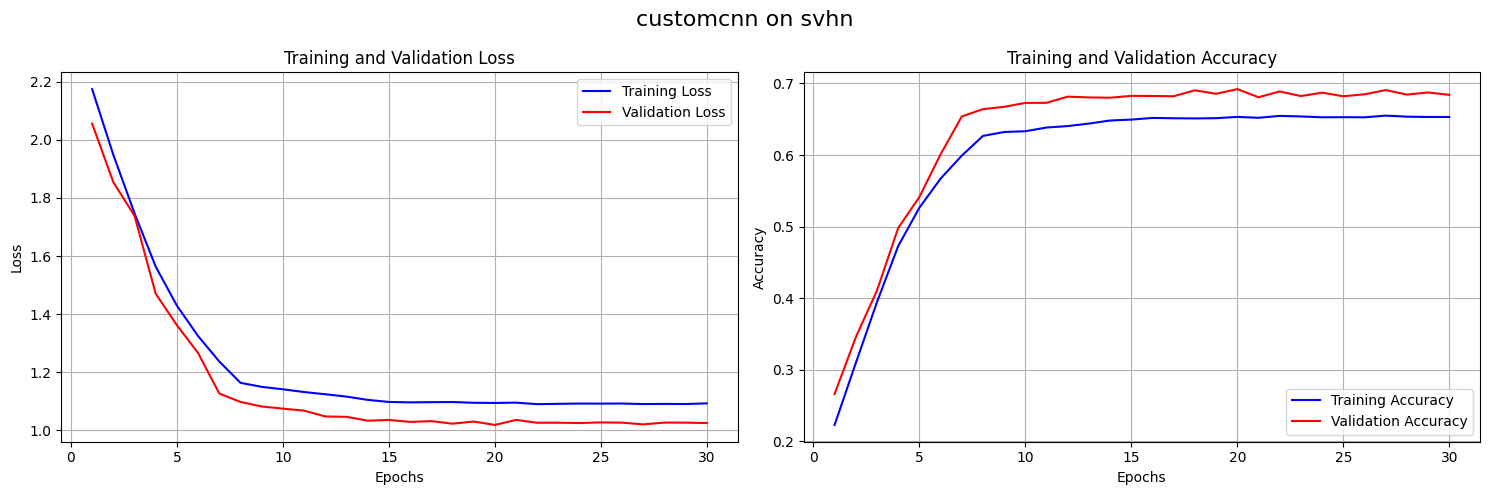

Training history plot saved to ./results/customcnn_on_svhn_history.png


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 1.0730 Acc: 0.6451


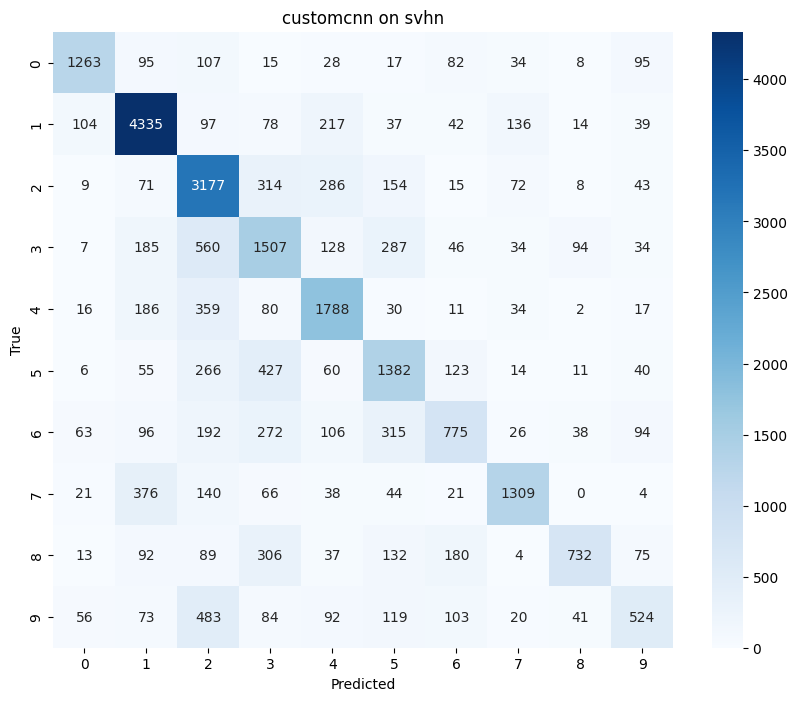

Confusion matrix plot saved to ./results/customcnn_on_svhn_confusion_matrix.png
Classification report saved to ./results/customcnn_on_svhn_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.810655,0.724197,0.764991,1744.000000
1,0.779116,0.850167,0.813092,5099.000000
2,0.580804,0.765727,0.660568,4149.000000
3,0.478565,0.522901,0.499751,2882.000000
4,0.643165,0.708680,0.674335,2523.000000
5,0.549066,0.579698,0.563967,2384.000000
6,0.554363,0.392008,0.459259,1977.000000
7,0.777778,0.648341,0.707185,2019.000000
8,0.772152,0.440964,0.561350,1660.000000
9,0.543005,0.328527,0.409375,1595.000000


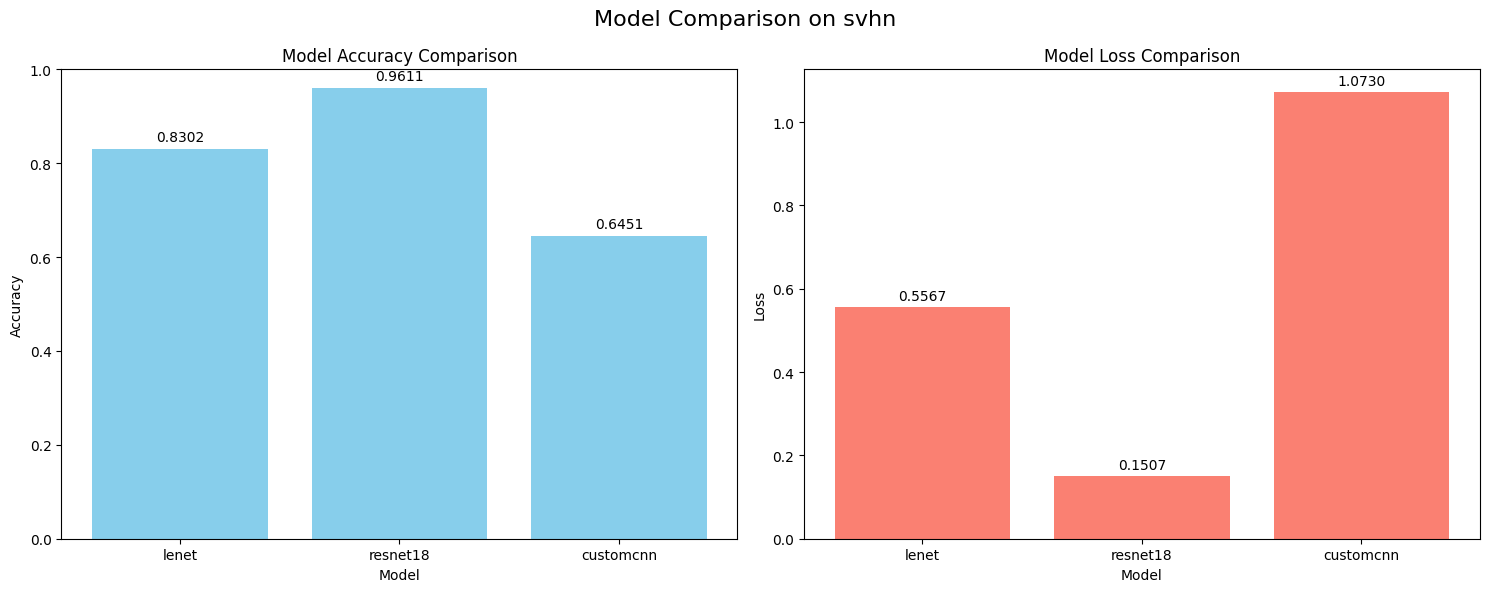

Model comparison plot saved to ./results/Model_Comparison_on_svhn_comparison.png

Final Results:

Dataset: cifar10
  lenet: Accuracy = 0.6212, Loss = 1.0754
  resnet18: Accuracy = 0.8960, Loss = 0.3486
  customcnn: Accuracy = 0.5411, Loss = 1.2688

Dataset: svhn
  lenet: Accuracy = 0.8302, Loss = 0.5567
  resnet18: Accuracy = 0.9611, Loss = 0.1507
  customcnn: Accuracy = 0.6451, Loss = 1.0730


In [18]:
results = run_experiment(
    dataset_names=['cifar10', 'svhn'],
    model_names=['lenet', 'resnet18', 'customcnn'],
    batch_size=128,
    epochs=30,
    learning_rate=0.001,
    weight_decay=1e-4,
    num_workers=2,
    save_dir='./results'
)